In [60]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [61]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)
productivity.index = productivity.samples

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [62]:
samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
index = target.index.drop(samples_to_drop)

In [63]:
'''Set sample names as index and shuffle data'''
productivity = productivity.loc[target.samples.values,:]
productivity.index= target.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=hna.index)
lna_rel = pd.Series(lna_rel, index=hna.index)

In [64]:
display(target.head(5))

,samples,Total.cells,HNA.cells,LNA.cells,Total.count.sd,HNA.sd,LNA.sd,Platform,Lake,Sample_16S,Season,Month,Year,Fraction,Site,Depth,Total_Sequences
M45S2F915,M45S2-915-2,1254145.438,2.707053e+05,9.834401e+05,32116.20862,748.942889,31389.15116,Accuri,Michigan,M45S2F915,Fall,September,2015,Free,MM45,Surface,11235
MDPH2F514,MUSDEPH-hypo-deep-514,3112909.391,1.406416e+06,1.706493e+06,42784.51351,25040.306320,17793.40622,Accuri,Muskegon,MDPH2F514,Spring,May,2014,Free,MDP,Deep,21536
MLBS2F915,MLBS2-915-2,9430611.393,2.727216e+06,6.703396e+06,335532.63510,151842.887500,186942.01220,Accuri,Michigan,MLBS2F915,Fall,September,2015,Free,MLB,Surface,24533
Fa13.BD.MLB.DN.1,MLB-D-N_September,4233418.108,1.249639e+06,2.983779e+06,66407.80988,48252.780490,20408.98544,Accuri,Michigan,Fa13.BD.MLB.DN.1,Fall,September,2013,Free,MLB,Deep,33653
Z14041F,Z14-41-1,6866121.758,2.134154e+06,4.731968e+06,104145.76160,50024.310950,60422.70801,Accuri,Inland,Z14041F,Summer,June,2015,Free,Whitmore,Surface,32904


In [65]:
from scipy.stats import pearsonr
p_p_hna = pearsonr(hna,target.loc[:,'Total.cells'])
p_p_lna = pearsonr(lna,target.loc[:,'Total.cells'])
p_p_hnalna = pearsonr(hna,lna)

print('Pearson correlation HNA vs. total cell counts: ' + str(p_p_hna[0]))
print('Pearson correlation LNA vs. total cell counts: ' + str(p_p_lna[0]))
print('Pearson correlation HNA vs. LNA: ' + str(p_p_hnalna[0]))

Pearson correlation HNA vs. total cell counts: 0.877775579566
Pearson correlation LNA vs. total cell counts: 0.978330967011
Pearson correlation HNA vs. LNA: 0.759564532226


In [66]:
p_p_hna_rel = pearsonr(hna_rel,target.loc[:,'Total.cells'])
p_p_lna_rel = pearsonr(lna_rel,target.loc[:,'Total.cells'])
p_p_hnalna_rel = pearsonr(hna_rel,lna_rel)

print('Pearson correlation rel. HNA vs. total cell counts: ' + str(p_p_hna_rel[0]))
print('Pearson correlation rel. LNA vs. total cell counts: ' + str(p_p_lna_rel[0]))
print('Pearson correlation rel. HNA vs. rel. LNA: ' + str(p_p_hnalna_rel[0]))

Pearson correlation rel. HNA vs. total cell counts: 0.0112213340283
Pearson correlation rel. LNA vs. total cell counts: -0.0112213340799
Pearson correlation rel. HNA vs. rel. LNA: -1.0


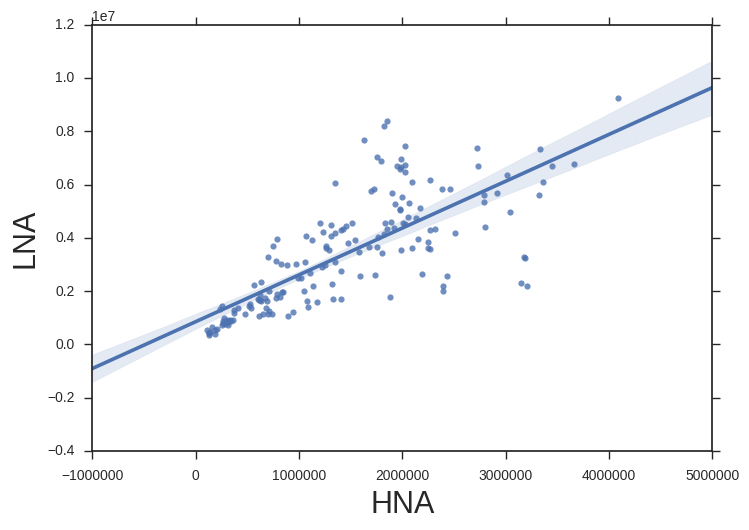

In [78]:
plt.figure()
sns.regplot(x=hna,y=lna)
plt.xlabel('HNA', size=22)
plt.xticks(size=10)
plt.ylabel('LNA', size=22)
plt.yticks(size=10)
plt.show()

In [68]:
'''Filtering based on productivity samples, not needed for first part of analysis'''
#retain only productivity samples 
#productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
#productivity = productivity[productivity.tot_bacprod < 90]

#idx_prod = productivity.samples.values
#display(idx_prod)
#prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
#prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
#prod_rel_error = prod_error/prod

'Filtering based on productivity samples, not needed for first part of analysis'

In [69]:
'''Parameter abun for initial filtering of OTUs'''
abun = 0.001

In [70]:
from analysis_functions import preprocess_df
data_abs = preprocess_df(data_abs,abun,True)
otus = list(data_abs.columns)

print('Number of OTUs: ' + str(len(otus)))

Number of OTUs: 1245


Let's calculate the _spearman correlation_ between the OTU's and the HNA/LNA-counts: 

In [71]:
from scipy.stats import kendalltau

k_hna = np.zeros(len(otus))
p_hna = np.zeros(len(otus))
k_lna = np.zeros(len(otus))
p_lna = np.zeros(len(otus))
for t in np.arange(0,len(otus)): 
    k_hna[t], p_hna[t] = kendalltau(hna,data_abs.loc[hna.index,otus[t]])
    k_lna[t], p_lna[t] = kendalltau(lna,data_abs.loc[lna.index,otus[t]])

results_abs = pd.DataFrame(k_hna, index=otus, columns=['k_hna'])
results_abs['p_hna'] = p_hna
results_abs['k_lna'] = k_lna
results_abs['p_lna'] = p_lna

results_abs.sort_values(by='k_hna', ascending=False, inplace=True)

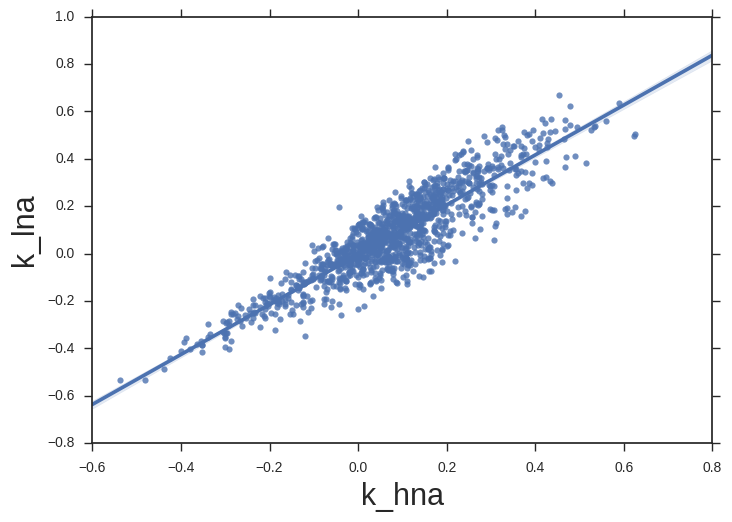

In [72]:
plt.figure()
sns.regplot(x='k_hna',y='k_lna', data=results_abs)
plt.xlabel('k_hna', size=22)
plt.xticks(size=10)
plt.ylabel('k_lna', size=22)
plt.yticks(size=10)
plt.show()

In [73]:
k_hna_rel = np.zeros(len(otus))
p_hna_rel = np.zeros(len(otus))
k_lna_rel = np.zeros(len(otus))
p_lna_rel = np.zeros(len(otus))

for t in np.arange(0,len(otus)): 
    k_hna_rel[t], p_hna_rel[t] = kendalltau(hna,data_rel.loc[hna.index,otus[t]])
    k_lna_rel[t], p_lna_rel[t] = kendalltau(lna,data_rel.loc[lna.index,otus[t]])

results_rel = pd.DataFrame(k_hna_rel, index=otus, columns=['k_hna'])
results_rel['p_hna'] = p_hna_rel
results_rel['k_lna'] = k_lna_rel
results_rel['p_lna'] = p_lna_rel

results_rel.sort_values(by='k_hna', ascending=False, inplace=True)

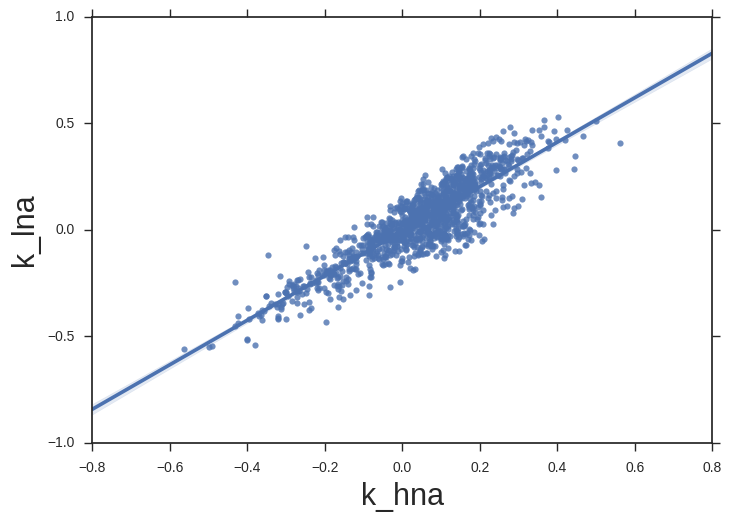

In [74]:
plt.figure()
sns.regplot(x='k_hna',y='k_lna', data=results_rel)
plt.xlabel('k_hna', size=22)
plt.xticks(size=10)
plt.ylabel('k_lna', size=22)
plt.yticks(size=10)
plt.show()

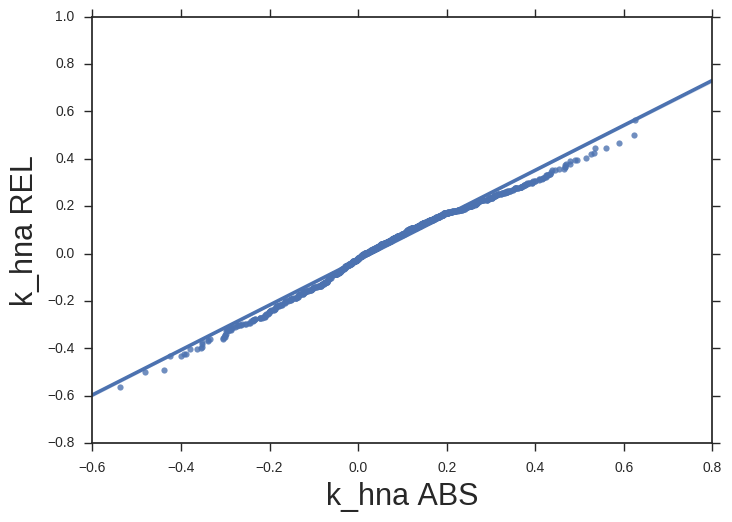

In [75]:
plt.figure()
sns.regplot(x=results_abs.loc[:,'k_hna'],y=results_rel.loc[:,'k_hna'])
plt.xlabel('k_hna ABS', size=22)
plt.xticks(size=10)
plt.ylabel('k_hna REL', size=22)
plt.yticks(size=10)
plt.show()

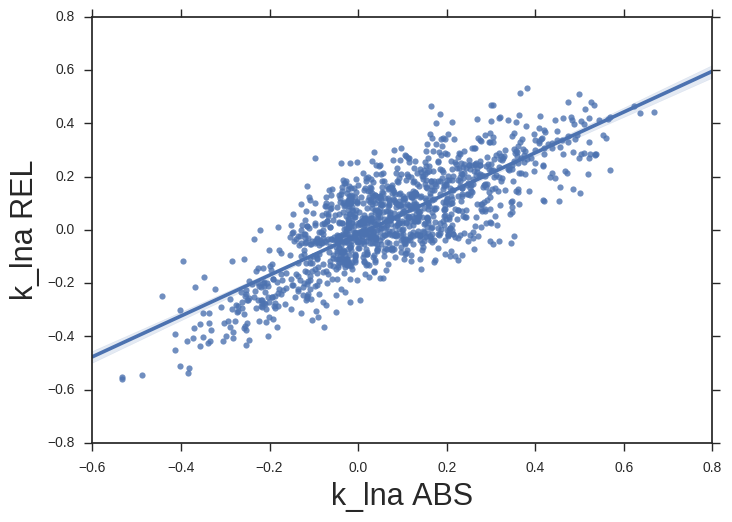

In [76]:
plt.figure()
sns.regplot(x=results_abs.loc[:,'k_lna'],y=results_rel.loc[:,'k_lna'])
plt.xlabel('k_lna ABS', size=22)
plt.xticks(size=10)
plt.ylabel('k_lna REL', size=22)
plt.yticks(size=10)
plt.show()

(Note that this number is the same whether we use absolute or relative abundances, as the filtering is based on a minimal _relative_ abundance.)